In [1]:
using PauliPropagation
using Base.Threads
using Plots

In [2]:
tn_vals = [9.99999254e-01,  9.99593653e-01,  9.95720077e-01,  9.88301532e-01,
        9.78553511e-01,  9.58023054e-01,  9.21986059e-01,  8.81726079e-01,
        8.49816779e-01,  8.24900527e-01,  7.91257641e-01,  7.37435202e-01,
        6.68573798e-01,  5.88096040e-01,  4.81874079e-01,  3.50316579e-01,
        2.26709331e-01,  1.39724659e-01,  7.86639143e-02,  4.24124371e-02,
        1.90595136e-02,  6.18879050e-03, -8.27168956e-04, -4.63372099e-03,
       -7.05202121e-03, -7.68387421e-03, -6.33121142e-03, -4.32594440e-03,
        6.52050191e-04,  1.72598340e-04,  5.64696020e-05, -7.70582375e-07]
tn_angles = LinRange(0, π/2, length(tn_vals));


google_vals = [1, 0.9957248494988796,0.9785691808859784,0.9227771228638144,0.8549387301071374,
    0.7790027681081058,0.6093954499261214,0.4257824480390532,0.2090085348069826,0.0116245678393245, -4.8872551798147e-09]
google_angles = [0.000, 0.100, 0.200, 0.300, 0.400,0.500,0.600,0.700,0.800,1.000,1.571];

In [3]:
function kickedisingcircuit(nq, nl; topology=nothing)
    
    # just in case a topology is not provided
    if isnothing(topology)
        topology = bricklayertopology(nq)
    end
    
    # define a layer of parametrized Rx-gates
    xlayer(circuit) = append!(circuit, (PauliRotation([:X], [qind]) for qind in 1:nq))
    
    # define a layer of fixed RZZ(π/2)-gates
    zzlayer(circuit) = append!(circuit, (PauliRotation([:Z, :Z], pair, π/2) for pair in topology))
    
    # define the empty circuit
    circuit = Gate[]
    # append to the circuit
    for _ in 1:nl
        zzlayer(circuit)
        xlayer(circuit)
    end
    tofastgates!(circuit)
    return circuit
end

kickedisingcircuit (generic function with 1 method)

In [4]:
# number of qubits
nq = 127
# the IBM Eagle topology
topology = ibmeagletopology
# 20 layers for the hardest simulation
nl = 20
# create the circuit
const circuit = kickedisingcircuit(nq, nl; topology);
# count the number of parameters
const nparams = countparameters(circuit)
# define the observable (note the index is 62 if you start with 0)
const pstr = PauliString(nq, :Z, 63)

PauliString(nqubits: 127, 1.0 * IIIIIIIIIIIIIIIIIIII...)

In [5]:
# perform the simulation for one x-angle
function onesimulation(angle; min_abs_coeff=0, max_weight=Inf)
    # set the angles of the Rx gates
    thetas = ones(nparams) * angle
    # propagate
    psum = propagate(circuit, pstr, thetas; min_abs_coeff, max_weight)
    # overlap with the zero-state
    return overlapwithzero(psum)
end

onesimulation (generic function with 1 method)

In [6]:
# set the truncations
min_abs_coeff = 1e-4
max_weight = 8

# prepare everything and run
x_angles = LinRange(0, π/2, 20)
expectations = zeros(length(x_angles))
t = @timed @threads for ii in eachindex(x_angles)
    angle = x_angles[ii]
    @time expectations[ii] = onesimulation(angle; min_abs_coeff, max_weight)
end

print("Total simulation time: ", t.time, " seconds")

  0.301899 seconds (448.99 k allocations: 122.470 MiB, 3.26% gc time, 606.17% compilation time)
  0.165886 seconds (346.18 k allocations: 79.907 MiB, 5.93% gc time, 962.69% compilation time)
  0.165953 seconds (346.36 k allocations: 80.456 MiB, 5.93% gc time, 966.68% compilation time)
  0.288544 seconds (436.02 k allocations: 86.723 MiB, 3.41% gc time, 600.63% compilation time)
  0.301873 seconds (448.92 k allocations: 122.466 MiB, 3.26% gc time, 593.24% compilation time)
  0.003262 seconds (29.95 k allocations: 6.209 MiB)
  0.060078 seconds (202.68 k allocations: 115.176 MiB, 16.38% gc time, 577.95% compilation time)
  0.074207 seconds (63.77 k allocations: 141.437 MiB, 7.54% gc time)
  0.342399 seconds (438.28 k allocations: 407.051 MiB, 5.47% gc time, 503.24% compilation time)
  0.229957 seconds (266.55 k allocations: 422.595 MiB, 8.14% gc time, 323.33% compilation time)
  0.066777 seconds (26.02 k allocations: 195.973 MiB, 0.89% gc time)
  0.443653 seconds (67.10 k allocations: 609

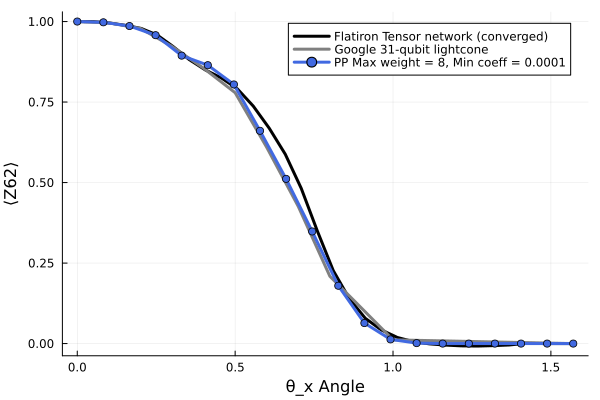

In [7]:
pl = plot(xlabel="θ_x Angle", ylabel="⟨Z62⟩")
plot!(tn_angles, tn_vals, label="Flatiron Tensor network (converged)", color="black", linewidth=3)
plot!(google_angles, google_vals, label="Google 31-qubit lightcone", color="grey", linewidth=3)
plot!(x_angles, expectations, marker=:circle, label="PP Max weight = $max_weight, Min coeff = $min_abs_coeff", linewidth=3, color="royalblue")
